In [298]:
import matplotlib.pyplot as plt
import numpy as np

class Kalman_v1:
    
    def __init__(self, A, B, P_init, Q, R, H):
        self.A = A
        self.B = B
        self.P = P_init
        self.Q = Q
        self.R = R
        self.H = H
    #Method for debugging purposes
    def getParams(self):
        print(self.A)
        print(self.B)
        print(self.P)
        print(self.Q)
        print(self.R)
        print(self.H)
    #Predict next state and error covariance
    def predict(self,x_k_prev,u_k_prev):
        x_k_predict = self.A@x_k_prev+self.B@u_k_prev
        self.P = self.A@self.P@np.transpose(self.A)+self.Q
        #Calculate Kalman Gain as well
        self.KalmanGain = self.P@np.transpose(self.H)@np.linalg.inv(self.H@self.P@np.transpose(self.H)+self.R)
        return x_k_predict
    #Update prediction
    def update(self,z_k,x_k_predict):
        x_k_corrected = x_k_predict+self.KalmanGain@(z_k-self.H@x_k_predict)
        self.P = (np.identity(len(self.KalmanGain@self.H))-self.KalmanGain@self.H)@self.P
        return x_k_corrected
    #Combine predict and update into one function
    def getValsAtNextTimeStep(self,x_k_prev,u_k_prev,z_k):
        x_k_predict = self.predict(x_k_prev,u_k_prev)
        return self.update(z_k,x_k_predict)
    

[[1.         0.03333333]
 [0.         1.        ]]
[[0.00055556]
 [0.03333333]]


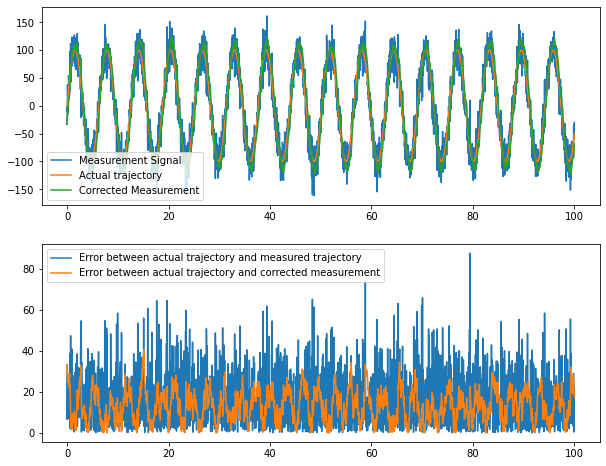

In [206]:
#Sinusoid
dt = 1/30
A = np.array([[1,dt],[0,1]])
B = np.array([[.5*dt**2],[dt]])
print(A)
print(B)
P = np.identity(len(A))
H = np.array([[1,0]])
sigma_accel = 10;
#Q = np.array([[(dt**4)/4,(dt**3)/2],[(dt**3)/2,(dt**2)]])*sigma_accel
Q = np.identity(len(A))*.05
sigma_z = 4;
R = np.zeros([1,1])
R[0] = sigma_z;
newFilter = Kalman_v1(A,B,P,Q,R,H)

t_init = 0
t_final = 100
t_steps = int(t_final/dt)

t = np.arange(t_init,t_final+dt,dt)
x = np.zeros([2,t_steps+1])

#newFilter.getParams()
#define trajectory
x_actual = 100*np.sin(t)
z_k = np.zeros(t_steps+1)
for i in range(t_steps+1):
    z_k[i] = x_actual[i]+np.random.normal(0,20)
    x_prev = np.zeros([2,1])
    u_prev = np.zeros([1,1])
    if i == 0:
        x_prev[0,0] = z_k[i]
        x_prev[1,0] = 0
        u_prev[0] = 0
    else:
        x_prev[0,0] = x[0,i-1]
        x_prev[1,0] = x[1,i-1]
        if i > 100:
            avg_accel = 0.0
            rg = 10
            for j in range(rg):
                avg_accel += (x[1,i+j-rg]-x[1,i+j-rg-1])/dt
                #print(x[1,i+j-rg-1]-x[1,i+j-rg-2])
            #u_prev[0] = avg_accel/rg
            #u_prev[0] = (x[1,i-1]-x[1,i-100])/(dt)
        #u_prev[0] = (-100*np.sin(t[i]))
            #print("estimated")
            #print(u_prev[0])
            #print(x[1,i-1])
            #print("actual")
            #print(u_prev[0])
            #print(-100*np.sin(t[i-1]))
            #u_prev[0] = 0
        #u_prev[0]=(x[1,i-1]-x[1,i-2])/dt
        #u_prev[0]=u_prev[0]/1000
        #print(u_prev)
    correction = newFilter.getValsAtNextTimeStep(x_prev,u_prev,z_k[i])
    x[:,i] = [correction[0], correction[1]]

error = np.abs(x_actual-x[0,:])
fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
line, = ax1.plot(t,z_k,label='Measurement Signal')
ax1.legend()
line, = ax1.plot(t,x_actual,label='Actual trajectory')
ax1.legend()
line, = ax1.plot(t,x[0,:],label='Corrected Measurement')
ax1.legend()
line, = ax2.plot(t, np.abs(x_actual-z_k),label='Error between actual trajectory and measured trajectory')
ax2.legend()
line, = ax2.plot(t,error,label='Error between actual trajectory and corrected measurement')
ax2.legend()

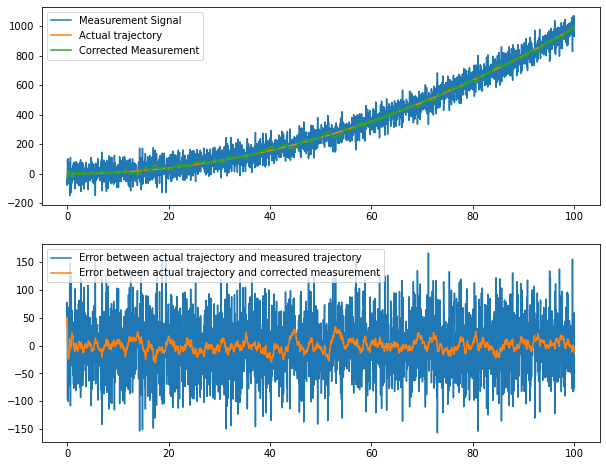

In [159]:
#Parabolic trajectory, 100 seconds
dt = 1/30;
A = np.array([[1,dt],[0,1]])
B = np.array([[.5*dt**2],[dt]])
P = np.identity(len(A))*10
H = np.array([[1,0]])
sigma_accel = 2;
Q = np.array([[dt**4/4,dt**3/2],[dt**3/2,dt**2]])*sigma_accel
Q = np.identity(len(A))*.01
sigma_z = 10;
R = np.zeros([1,1])
R[0] = sigma_z;
newFilter = Kalman_v1(A,B,P,Q,R,H)

t_init = 0
t_final = 100
t_steps = int(t_final/dt)

t = np.arange(t_init,t_final+dt,dt)
x = np.zeros([2,t_steps+1])

#newFilter.getParams()
#define trajectory
x_actual = .1*(t**2-t)
z_k = np.zeros(t_steps+1)
for i in range(t_steps+1):
    z_k[i] = x_actual[i]+np.random.normal(0,50)
    x_prev = np.zeros([2,1])
    u_prev = np.zeros([1,1])
    if i == 0:
        x_prev[0,0] = z_k[i]
        x_prev[1,0] = 0
        u_prev[0] = 0
    else:
        x_prev[0,0] = x[0,i-1]
        x_prev[1,0] = x[1,i-1]
        u_prev[0] = (x[1,i-1]-x[1,i-2])/(3*dt)
    correction = np.ndarray.flatten(newFilter.getValsAtNextTimeStep(x_prev,u_prev,z_k[i]))
    x[:,i] = [correction[0], correction[1]]

error = x_actual-x[0,:]
fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
line, = ax1.plot(t,z_k,label='Measurement Signal')
ax1.legend()
line, = ax1.plot(t,x_actual,label='Actual trajectory')
ax1.legend()
line, = ax1.plot(t,x[0,:],label='Corrected Measurement')
ax1.legend()
line, = ax2.plot(t, x_actual-z_k,label='Error between actual trajectory and measured trajectory')
ax2.legend()
line, = ax2.plot(t,error,label='Error between actual trajectory and corrected measurement')
ax2.legend()

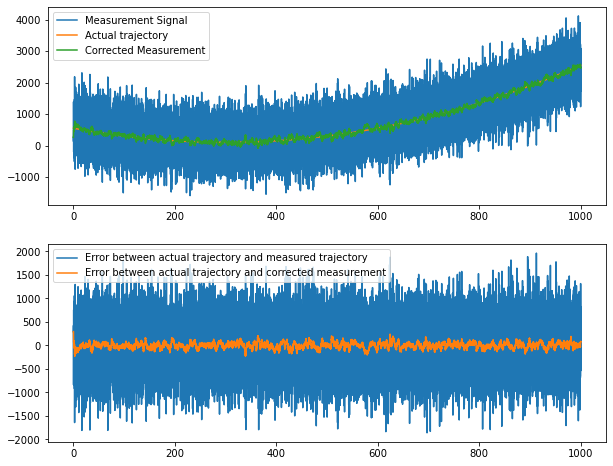

In [160]:
#Parabolic trajectory, up to 1000 seconds
dt = 1/30;
A = np.array([[1,dt],[0,1]])
B = np.array([[.5*dt**2],[dt]])
P = np.identity(len(A))
H = np.array([[1,0]])
sigma_accel = .25;
Q = np.array([[dt**4/4,dt**3/2],[dt**3/2,dt**2]])*sigma_accel
sigma_z = 10;
R = np.zeros([1,1])
R[0] = sigma_z;
newFilter = Kalman_v1(A,B,P,Q,R,H)

t_init = 0
t_final = 1000
t_steps = int(t_final/dt)

t = np.arange(t_init,t_final+dt,dt)
x = np.zeros([2,t_steps+1])

#newFilter.getParams()
#define trajectory
x_actual = .005*(t-300)**2+100
z_k = np.zeros(t_steps+1)
for i in range(t_steps+1):
    z_k[i] = x_actual[i]+np.random.normal(0,500)
    x_prev = np.zeros([2,1])
    u_prev = np.zeros([1,1])
    if i == 0:
        x_prev[0,0] = z_k[i]
        x_prev[1,0] = 0
        u_prev[0] = 0           
    else:
        x_prev[0,0] = x[0,i-1]
        x_prev[1,0] = x[1,i-1]
        #u_prev[0] = (x[1,i]-x[1,i-1])/dt
    correction = np.ndarray.flatten(newFilter.getValsAtNextTimeStep(x_prev,u_prev,z_k[i]))
    x[:,i] = [correction[0], correction[1]]

error = x_actual-x[0,:]
fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
line, = ax1.plot(t,z_k,label='Measurement Signal')
ax1.legend()
line, = ax1.plot(t,x_actual,label='Actual trajectory')
ax1.legend()
line, = ax1.plot(t,x[0,:],label='Corrected Measurement')
ax1.legend()
line, = ax2.plot(t, x_actual-z_k,label='Error between actual trajectory and measured trajectory')
ax2.legend()
line, = ax2.plot(t,error,label='Error between actual trajectory and corrected measurement')
ax2.legend()

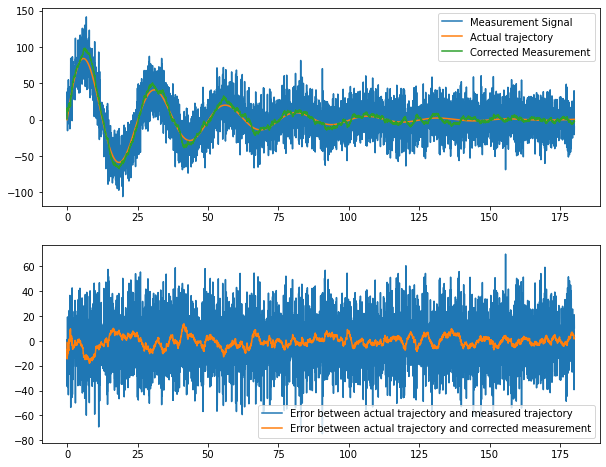

In [50]:
#Decaying sinusoid
dt = 1/30;
A = np.array([[1,dt],[0,1]])
B = np.array([[.5*dt**2],[dt]])
P = np.identity(len(A))
H = np.array([[1,0]])
sigma_accel = .25;
Q = np.array([[dt**4/4,dt**3/2],[dt**3/2,dt**2]])*sigma_accel
sigma_z = 1;
R = np.zeros([1,1])
R[0] = sigma_z;
newFilter = Kalman_v1(A,B,P,Q,R,H)

t_init = 0
t_final = 180
t_steps = int(t_final/dt)

t = np.arange(t_init,t_final+dt,dt)
x = np.zeros([2,t_steps+1])
#newFilter.getParams()
#define trajectory
x_actual = 100*np.exp(-t/35)*np.sin(t/4)
z_k = np.zeros(t_steps+1)
for i in range(t_steps+1):
    z_k[i] = x_actual[i]+np.random.normal(0,20)
    x_prev = np.zeros([2,1])
    u_prev = np.zeros([1,1])
    if i == 0:
        x_prev[0,0] = z_k[i]
        x_prev[1,0] = 0
        u_prev[0] = 0
    else:
        x_prev[0,0] = x[0,i-1]
        x_prev[1,0] = x[1,i-1]
        #u_prev[0] = (x[1,i]-x[1,i-1])/dt
    correction = np.ndarray.flatten(newFilter.getValsAtNextTimeStep(x_prev,u_prev,z_k[i]))
    x[:,i] = [correction[0], correction[1]]

error = x_actual-x[0,:]
fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
line, = ax1.plot(t,z_k,label='Measurement Signal')
ax1.legend()
line, = ax1.plot(t,x_actual,label='Actual trajectory')
ax1.legend()
line, = ax1.plot(t,x[0,:],label='Corrected Measurement')
ax1.legend()
line, = ax2.plot(t, x_actual-z_k,label='Error between actual trajectory and measured trajectory')
ax2.legend()
line, = ax2.plot(t,error,label='Error between actual trajectory and corrected measurement')
ax2.legend()

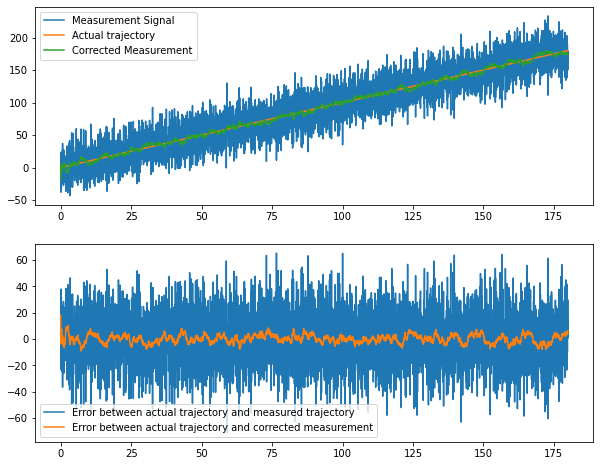

In [54]:
#Straight line, 0 to 180 seconds
dt = 1/30;
A = np.array([[1,dt],[0,1]])
B = np.array([[.5*dt**2],[dt]])
P = np.identity(len(A))
H = np.array([[1,0]])
sigma_accel = .25;
Q = np.array([[dt**4/4,dt**3/2],[dt**3/2,dt**2]])*sigma_accel
sigma_z = 1;
R = np.zeros([1,1])
R[0] = sigma_z;
newFilter = Kalman_v1(A,B,P,Q,R,H)

t_init = 0
t_final = 180
t_steps = int(t_final/dt)

t = np.arange(t_init,t_final+dt,dt)
x = np.zeros([2,t_steps+1])
#newFilter.getParams()
#define trajectory
x_actual = t
z_k = np.zeros(t_steps+1)
for i in range(t_steps+1):
    z_k[i] = x_actual[i]+np.random.normal(0,20)
    x_prev = np.zeros([2,1])
    u_prev = np.zeros([1,1])
    if i == 0:
        x_prev[0,0] = z_k[i]
        x_prev[1,0] = 0
        u_prev[0] = 0
    else:
        x_prev[0,0] = x[0,i-1]
        x_prev[1,0] = x[1,i-1]
        #u_prev[0] = (x[1,i]-x[1,i-1])/dt
    correction = np.ndarray.flatten(newFilter.getValsAtNextTimeStep(x_prev,u_prev,z_k[i]))
    x[:,i] = [correction[0], correction[1]]
error = x_actual-x[0,:]
fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
line, = ax1.plot(t,z_k,label='Measurement Signal')
ax1.legend()
line, = ax1.plot(t,x_actual,label='Actual trajectory')
ax1.legend()
line, = ax1.plot(t,x[0,:],label='Corrected Measurement')
ax1.legend()
line, = ax2.plot(t, x_actual-z_k,label='Error between actual trajectory and measured trajectory')
ax2.legend()
line, = ax2.plot(t,error,label='Error between actual trajectory and corrected measurement')
ax2.legend()

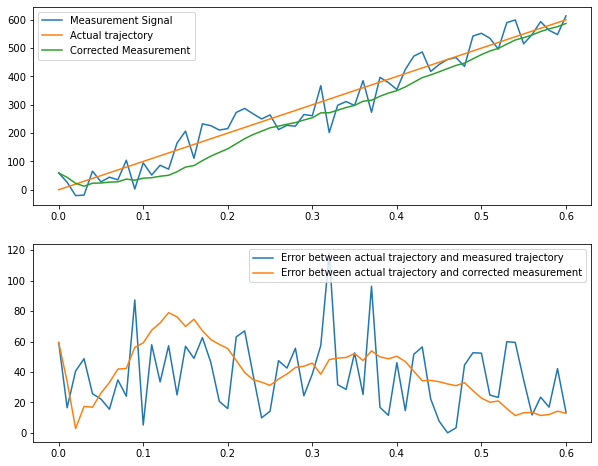

In [239]:
#Straight line, from 0 seconds to .6 seconds. Simulates a fast object that is in the image for a fraction of a second.
dt = 1/100;
A = np.array([[1,dt],[0,1]])
B = np.array([[.5*dt**2],[dt]])
P = np.identity(len(A))
H = np.array([[1,0]])
sigma_accel = 1;
Q = np.array([[dt**4/4,dt**3/2],[dt**3/2,dt**2]])*sigma_accel
sigma_z = .1;
R = np.zeros([1,1])
R[0] = sigma_z;
newFilter = Kalman_v1(A,B,P,Q,R,H)

t_init = 0
t_final = .6
t_steps = int(t_final/dt)

t = np.arange(t_init,t_final+dt,dt)
x = np.zeros([2,t_steps+1])
#newFilter.getParams()
#define trajectory
x_actual = 1000*t
z_k = np.zeros(t_steps+1)
x_prev = np.zeros([2,1])
u_prev = np.zeros([1,1])
for i in range(t_steps+1):
    z_k[i] = x_actual[i]+np.random.normal(0,50)
    if i == 0:
        x_prev[0,0] = z_k[i]
        x_prev[1,0] = 0
        u_prev[0] = 0
    else:
        x_prev[0,0] = x[0,i-1]
        x_prev[1,0] = x[1,i-1]
        #u_prev[0] = (x[1,i-1]-x[1,i-2])/dt
    corrected_val = newFilter.getValsAtNextTimeStep(x_prev,u_prev,z_k[i])
    x[0,i] = corrected_val[0,0]
    x[1,i] = corrected_val[1,0]

error = x_actual-x[0,:]
fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
line, = ax1.plot(t,z_k,label='Measurement Signal')
ax1.legend()
line, = ax1.plot(t,x_actual,label='Actual trajectory')
ax1.legend()
line, = ax1.plot(t,x[0,:],label='Corrected Measurement')
ax1.legend()
line, = ax2.plot(t, np.abs(x_actual-z_k),label='Error between actual trajectory and measured trajectory')
ax2.legend()
line, = ax2.plot(t,np.abs(error),label='Error between actual trajectory and corrected measurement')
ax2.legend()

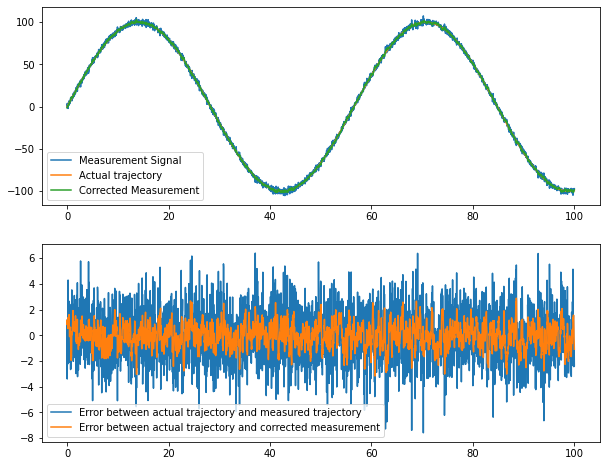

In [58]:
#Sinusoid, minimal noise
dt = 1/30
A = np.array([[1,dt],[0,1]])
B = np.array([[.5*dt**2],[dt]])
P = np.identity(len(A))
H = np.array([[1,0]])
sigma_accel = 10000;
Q = np.array([[(dt**4)/4,(dt**3)/2],[(dt**3)/2,(dt**2)]])*sigma_accel
sigma_z = 5;
R = np.zeros([1,1])
R[0] = sigma_z;
newFilter = Kalman_v1(A,B,P,Q,R,H)

t_init = 0
t_final = 100
t_steps = int(t_final/dt)

t = np.arange(t_init,t_final+dt,dt)
x = np.zeros([2,t_steps+1])

#newFilter.getParams()
#define trajectory
x_actual = 100*np.sin(t/9)
z_k = np.zeros(t_steps+1)
for i in range(t_steps+1):
    z_k[i] = x_actual[i]+np.random.normal(0,2)
    x_prev = np.zeros([2,1])
    u_prev = np.zeros([1,1])
    if i == 0:
        x_prev[0,0] = z_k[i]
        x_prev[1,0] = 0
        u_prev[0] = 0
    else:
        x_prev[0,0] = x[0,i-1]
        x_prev[1,0] = x[1,i-1]
        #if i > 10:
            #u_prev[0] = (x[1,i-1]**2-x[1,i-10]**2)/(2*(x[0,i-1]-x[0,i-10]))
            #u_prev[0] = 0
        #u_prev[0]=0
        #u_prev[0] = -100/36*np.sin(t[i]/6)
        #print(u_prev)
    correction = newFilter.getValsAtNextTimeStep(x_prev,u_prev,z_k[i])
    x[:,i] = [correction[0], correction[1]]

error = x_actual-x[0,:]
fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
line, = ax1.plot(t,z_k,label='Measurement Signal')
ax1.legend()
line, = ax1.plot(t,x_actual,label='Actual trajectory')
ax1.legend()
line, = ax1.plot(t,x[0,:],label='Corrected Measurement')
ax1.legend()
line, = ax2.plot(t, x_actual-z_k,label='Error between actual trajectory and measured trajectory')
ax2.legend()
line, = ax2.plot(t,error,label='Error between actual trajectory and corrected measurement')
ax2.legend()

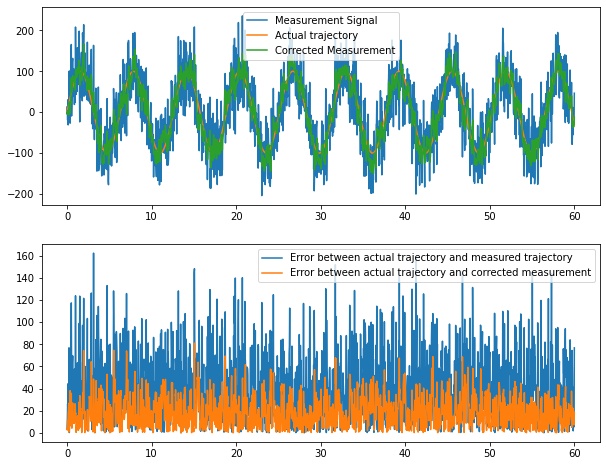

In [273]:
#Sinusoid
dt = 1/30
A = np.array([[1,dt,.5*dt**2,1/6*dt**3],[0,1,dt,.5*dt**2],[0,0,1,dt],[0,0,0,1]])
B = np.zeros([4,1])
P = np.identity(len(A))
H = np.array([[1,0,0,0]])
sigma_accel = 10;
#Q = np.array([[(dt**4)/4,(dt**3)/2],[(dt**3)/2,(dt**2)]])*sigma_accel
Q = np.identity(len(A))*.5
sigma_z = 5;
R = np.zeros([1,1])
R[0] = sigma_z;
newFilter = Kalman_v1(A,B,P,Q,R,H)

t_init = 0
t_final = 60
t_steps = int(t_final/dt)

t = np.arange(t_init,t_final+dt,dt)
x = np.zeros([4,t_steps+1])

#newFilter.getParams()
#define trajectory
x_actual = 100*np.sin(t)
z_k = np.zeros(t_steps+1)
for i in range(t_steps+1):
    z_k[i] = x_actual[i]+np.random.normal(0,50)
    x_prev = np.zeros([4,1])
    if i == 0:
        x_prev[0,0] = z_k[i]
    else:
        x_prev[0,0] = x[0,i-1]
        x_prev[1,0] = x[1,i-1]
        x_prev[2,0] = x[2,i-1]
        x_prev[3,0] = x[3,i-1]
        #if i > 100:
            #avg_accel = 0.0
            #rg = 10
            #for j in range(rg):
                #avg_accel += (x[1,i+j-rg]-x[1,i+j-rg-1])/dt
                #print(x[1,i+j-rg-1]-x[1,i+j-rg-2])
            #u_prev[0] = avg_accel/rg
            #u_prev[0] = (x[1,i-1]-x[1,i-100])/(dt)
        #u_prev[0] = (-100*np.sin(t[i]))
            #print("estimated")
            #print(u_prev[0])
            #print(x[1,i-1])
            #print("actual")
            #print(u_prev[0])
            #print(-100*np.sin(t[i-1]))
            #u_prev[0] = 0
        #u_prev[0]=(x[1,i-1]-x[1,i-2])/dt
        #u_prev[0]=u_prev[0]/1000
        #print(u_prev)
    correction = newFilter.getValsAtNextTimeStep(x_prev,u_prev,z_k[i])
    x[:,i] = [correction[0], correction[1], correction[2], correction[3]]

error = np.abs(x_actual-x[0,:])
fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
line, = ax1.plot(t,z_k,label='Measurement Signal')
ax1.legend()
line, = ax1.plot(t,x_actual,label='Actual trajectory')
ax1.legend()
line, = ax1.plot(t,x[0,:],label='Corrected Measurement')
ax1.legend()
line, = ax2.plot(t, np.abs(x_actual-z_k),label='Error between actual trajectory and measured trajectory')
ax2.legend()
line, = ax2.plot(t,error,label='Error between actual trajectory and corrected measurement')
ax2.legend()

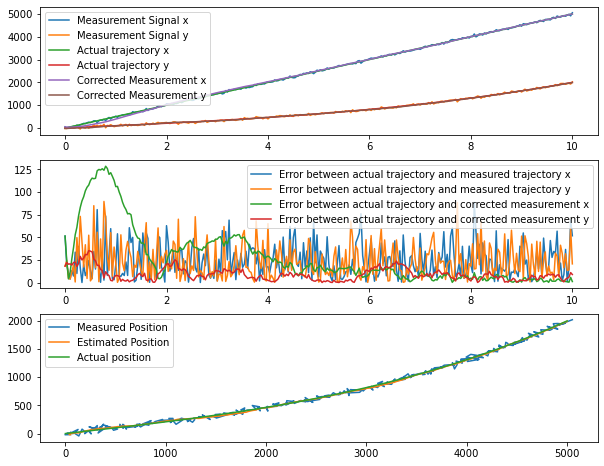

In [342]:
#Position tracking (x and y positions)
dt = 1/30
A_sub = np.array([[1,dt,.5*dt**2],[0,1,dt],[0,0,1]])
A = np.zeros([6,6])
A[0:3,0:3] = A_sub
A[3:6,3:6] = A_sub

B = np.zeros([6,1])
P = np.identity(len(A))

H = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])
sigma_accel = 10;
#Q = np.array([[(dt**4)/4,(dt**3)/2],[(dt**3)/2,(dt**2)]])*sigma_accel
Q = np.identity(len(A))*.005
sigma_z = 3;
#R = np.zeros([1,1])
R = np.identity(2)*sigma_z;
newFilter = Kalman_v1(A,B,P,Q,R,H)

t_init = 0
t_final = 10
t_steps = int(t_final/dt)

t = np.arange(t_init,t_final+dt,dt)
x = np.zeros([6,t_steps+1])

#newFilter.getParams()
#define trajectory
#x_actual = 100*np.sin(t/2)
#y_actual = 100*np.cos(t*2)
x_actual = 500*t
y_actual = 100*t+t**3
z_k = np.zeros([t_steps+1,2])
for i in range(t_steps+1):
    z_k[i,:] = [x_actual[i]+np.random.normal(0,30),y_actual[i]+np.random.normal(0,30)]
    x_prev = np.zeros([6,1])
    if i == 0:
        x_prev[0,0] = z_k[i,0]
        x_prev[3,0] = z_k[i,1]
    else:
        x_prev[0,0] = x[0,i-1]
        x_prev[1,0] = x[1,i-1]
        x_prev[2,0] = x[2,i-1]
        x_prev[3,0] = x[3,i-1]
        x_prev[4,0] = x[4,i-1]
        x_prev[5,0] = x[5,i-1]
        #if i > 100:
            #avg_accel = 0.0
            #rg = 10
            #for j in range(rg):
                #avg_accel += (x[1,i+j-rg]-x[1,i+j-rg-1])/dt
                #print(x[1,i+j-rg-1]-x[1,i+j-rg-2])
            #u_prev[0] = avg_accel/rg
            #u_prev[0] = (x[1,i-1]-x[1,i-100])/(dt)
        #u_prev[0] = (-100*np.sin(t[i]))
            #print("estimated")
            #print(u_prev[0])
            #print(x[1,i-1])
            #print("actual")
            #print(u_prev[0])
            #print(-100*np.sin(t[i-1]))
            #u_prev[0] = 0
        #u_prev[0]=(x[1,i-1]-x[1,i-2])/dt
        #u_prev[0]=u_prev[0]/1000
        #print(u_prev)
    correction = newFilter.getValsAtNextTimeStep(x_prev,u_prev,[[z_k[i,0]],[z_k[i,1]]])
    x[:,i] = [correction[0], correction[1], correction[2], correction[3], correction[4], correction[5]]
    #print(correction)
error = np.abs(x_actual-x[0,:])
fig = plt.figure(figsize=(10,8))
ax1 = plt.subplot(311)
ax2 = plt.subplot(312)
ax3 = plt.subplot(313)
line, = ax1.plot(t,z_k[:,0],label='Measurement Signal x')
ax1.legend()
line, = ax1.plot(t,z_k[:,1],label='Measurement Signal y')
ax1.legend()
line, = ax1.plot(t,x_actual,label='Actual trajectory x')
ax1.legend()
line, = ax1.plot(t,y_actual,label='Actual trajectory y')
ax1.legend()
line, = ax1.plot(t,x[0,:],label='Corrected Measurement x')
ax1.legend()
line, = ax1.plot(t,x[3,:],label='Corrected Measurement y')
ax1.legend()
line, = ax2.plot(t, np.abs(x_actual-z_k[:,0]),label='Error between actual trajectory and measured trajectory x')
ax2.legend()
line, = ax2.plot(t, np.abs(y_actual-z_k[:,1]),label='Error between actual trajectory and measured trajectory y')
ax2.legend()
line, = ax2.plot(t,np.abs(x_actual-x[0,:]),label='Error between actual trajectory and corrected measurement x')
ax2.legend()
line, = ax2.plot(t,np.abs(y_actual-x[3,:]),label='Error between actual trajectory and corrected measurement y')
ax2.legend()
line, = ax3.plot(z_k[:,0],z_k[:,1],label='Measured Position')
ax3.legend()
line, = ax3.plot(x[0,:],x[3,:],label='Estimated Position')
ax3.legend()
line, = ax3.plot(x_actual,y_actual,label='Actual position')
ax3.legend()